[2017-08-23 17:38:54.956936]:get_signal:20:Loading [signal: FA7773JN_0][group: 1800_600/raw/baseline_removal]
[2017-08-23 17:38:54.966799]:get_signal:20:Loading [signal: FA7773JN_1][group: 1800_600/raw/baseline_removal]
[2017-08-23 17:38:54.982673]:get_signal:20:Loading [signal: FA7773JS_0][group: 1800_600/raw/baseline_removal]
[2017-08-23 17:38:55.001124]:get_signal:20:Loading [signal: FA7773TC_0][group: 1800_600/raw/baseline_removal]
[2017-08-23 17:38:55.018578]:get_signal:20:Loading [signal: FA7773TT_0][group: 1800_600/raw/baseline_removal]
[2017-08-23 17:38:55.036941]:get_signal:20:Loading [signal: FA7773U1_0][group: 1800_600/raw/baseline_removal]
[2017-08-23 17:38:55.055436]:get_signal:20:Loading [signal: FA7773U3_0][group: 1800_600/raw/baseline_removal]
[2017-08-23 17:38:55.073984]:get_signal:20:Loading [signal: FA7773U4_0][group: 1800_600/raw/baseline_removal]
[2017-08-23 17:38:55.092828]:get_signal:20:Loading [signal: FA7773U4_1][group: 1800_600/raw/baseline_removal]
[2017-08-2

1800_600/raw/baseline_removal
1800_600/raw
['1800_600/raw/baseline_removal']
[('1800_600/raw/baseline_removal', u'FA7773JN_0'), ('1800_600/raw/baseline_removal', u'FA7773JN_1'), ('1800_600/raw/baseline_removal', u'FA7773JS_0'), ('1800_600/raw/baseline_removal', u'FA7773TC_0'), ('1800_600/raw/baseline_removal', u'FA7773TT_0'), ('1800_600/raw/baseline_removal', u'FA7773U1_0'), ('1800_600/raw/baseline_removal', u'FA7773U3_0'), ('1800_600/raw/baseline_removal', u'FA7773U4_0'), ('1800_600/raw/baseline_removal', u'FA7773U4_1'), ('1800_600/raw/baseline_removal', u'FA7773U5_0'), ('1800_600/raw/baseline_removal', u'FA7773U6_0'), ('1800_600/raw/baseline_removal', u'FA77745R_0'), ('1800_600/raw/baseline_removal', u'FA77745S_0'), ('1800_600/raw/baseline_removal', u'FA77748S_0'), ('1800_600/raw/baseline_removal', u'FA777494_0'), ('1800_600/raw/baseline_removal', u'FA7774C6_0')]


[2017-08-23 17:38:55.150481]:get_signal:20:Loading [signal: FA77745R_0][group: 1800_600/raw/baseline_removal]
[2017-08-23 17:38:55.169816]:get_signal:20:Loading [signal: FA77745S_0][group: 1800_600/raw/baseline_removal]
[2017-08-23 17:38:55.186587]:get_signal:20:Loading [signal: FA77748S_0][group: 1800_600/raw/baseline_removal]
[2017-08-23 17:38:55.204439]:get_signal:20:Loading [signal: FA777494_0][group: 1800_600/raw/baseline_removal]
[2017-08-23 17:38:55.236189]:get_signal:20:Loading [signal: FA7774C6_0][group: 1800_600/raw/baseline_removal]


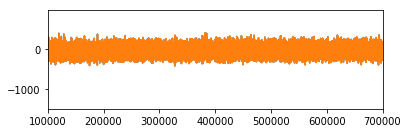

In [4]:
# %load pre_processing.py
from pre_epi_seizures.storage_utils.storage_utils_hdf5 import \
    load_signal, save_signal, delete_signal, list_group_signals

from pre_epi_seizures.storage_utils.data_handlers import *

from pre_epi_seizures.logging_utils.formatter_logging import logger as _logger

from filtering import baseline_removal, noise_removal,\
    create_filtered_dataset, eks_smoothing

from segmentation import rpeak_detection, create_heart_beat_dataset,\
    compute_beats, find_rpeaks, detect_rpeaks, hrv_computation

from resampling import resample_rpeaks, interpolate_signal, decimation

from visual_inspection import visual_inspection

from morphology import *
# from Filtering.gaussian_fit import get_phase, mean_extraction,\
#     beat_fitter, ecg_model

from Filtering.filter_signal import filter_signal

from Filtering.eksmoothing import *

from biosppy.signals import ecg

from memory_profiler import profile

import time
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import logging
import sys
import copy
import memory_profiler
import functools

def compress(path_to_load, group_name_list):
    print 'before loading' 
    print group_name_list

    # Memory loop (one signal at a time)
    for i, group_name in enumerate(group_name_list):
        signal_structure = load_signal(path_to_load, [group_name])
        one_signal_structure = get_one_signal_structure(signal_structure, group_name)
        record = get_multiple_records(one_signal_structure)


def extract_feature(feature, arg_list):
    return locals[feature](arg_list)

def get_names(group_name_list):
    return [group_name[1] for group_name in group_name_list]

def load_feature(path_to_load, feature_to_load, files='just_new_data', sampling_rate=1000, **feature_groups_required):

    feature_group_to_process = feature_groups_required['feature_group_to_process']

    feature_group_extracted = [feature_group_to_process + '/' + feature_to_load]

    print feature_group_to_process
    print feature_group_extracted

    if files=='all_new':
        print feature_groups_required
        for k in feature_groups_required.keys():
            feature_groups_required[k] = list_group_signals(path_to_load, feature_groups_required[k])['signals']
        names_to_save = get_names(list_group_signals(path_to_load, feature_group_to_process)['signals'])

    if files=='just_new_data':
        print feature_groups_required
        for k in feature_groups_required.keys():
            feature_groups_required[k] = list_group_signals(path_to_load, feature_groups_required[k])['signals']
        #*****************IMPORTANT CHANGE***************************
        names_to_save = get_names(list_group_signals(path_to_load, feature_group_to_process)['signals'])

    if files=='existent':
        feature_group_name_extracted = list_group_signals(path_to_load, feature_group_extracted[0 ])['signals']
        try:
            signal_structure = load_signal(path_to_load, feature_group_name_extracted)
            extracted_features = [get_multiple_records(get_one_signal_structure(signal_structure, group_name)) for group_name in feature_group_name_extracted]
            return extracted_features
        except Exception as e:
            _logger.debug(e)



    for k in feature_groups_required.keys():
        signal_structure = load_signal(path_to_load, feature_groups_required[k])
        feature_groups_required[k] = [get_multiple_records(get_one_signal_structure(signal_structure, group_name)) for group_name in feature_groups_required[k]]

    print feature_groups_required

    for i, name in enumerate(names_to_save):
        dict_to_process = {}
        for k in feature_groups_required.keys():
            dict_to_process[k] = [feature_groups_required[k][i]]
        print dict_to_process
        extracted_features, mdata_features = globals()[feature_to_load](feature_groups_required, sampling_rate)
        print extracted_features
        print mdata_features
        delete_signal(path_to_load, [name], feature_group_extracted)
        save_signal(path_to_load, extracted_features, mdata_features, [name], feature_group_extracted)

    # # Memory Intensive
    # extracted_features, mdata_features = globals()[feature_to_load](feature_groups_required, sampling_rate)

    # delete_signal(path_to_load, names_to_save, feature_group_extracted)
    # save_signal(path_to_load, extracted_features, mdata_features, names_to_save, feature_group_extracted)




# @profile
def main():

    #signal
    time_before_seizure = 30
    time_after_seizure = 10
    # path_to_load = '~/Desktop/phisionet_seizures_new.h5'
    # sampling_rate = 1000
    path_to_load = '~/Desktop/seizure_datasets_new.h5'
    # name_list = [str(time_before_seizure*60) + '_' + str(time_after_seizure*60)]
    # group_list_raw = ['raw']
    # group_list_baseline_removal = ['medianFIR']
    # group_list_noise_removal = ['FIR_lowpass_40hz']
    # group_list_esksmooth = ['esksmooth']
    dataset_name = str(
    time_before_seizure*60) + '_' + str(time_after_seizure*60)
    raw_name = 'raw'
    baseline_removal_name = 'baseline_removal'
    raw_dataset_name = dataset_name + '/' + raw_name
    baseline_removal_dataset_name = raw_dataset_name + '/' + baseline_removal_name
    print baseline_removal_dataset_name
    feature_group_to_process = baseline_removal_dataset_name + '/' + 'decimation'
    # group_name_list = list_group_signals(path_to_load, group_list[0])['signals']
    # compress(path_to_load, group_name_list)

    raw = load_feature(path_to_load, raw_name, files='existent', feature_group_to_process=dataset_name)

    baseline_removal = load_feature(path_to_load, baseline_removal_name, files='existent', feature_group_to_process=raw_dataset_name)

    # decimated = load_feature(path_to_load, 'decimation', files='existent', feature_group_to_process=baseline_removal_dataset_name)
    # rpeaks = load_feature(path_to_load, 'rpeak_detection', files='existent', feature_group_to_process=baseline_removal_dataset_name)

    # hrv = load_feature(path_to_load, 'hrv_computation', files='existent', feature_group_to_process=baseline_removal_dataset_name + '/' + 'rpeak_detection')
    # eks = load_feature(path_to_load, 'eks_smoothing', files='all_new', feature_group_to_process=baseline_removal_dataset_name + '/' + 'decimation', rpeak_group_to_process=baseline_removal_dataset_name + '/' + 'decimation' + '/' + 'rpeak_detection')


    start = 100 * 1000
    end = 700 * 1000
    sz_nr = 14

    
    signal = baseline_removal
    n = np.linspace(0, len(signal[sz_nr])-1, len(signal[sz_nr]))
    plt.subplot(2,1,1)
    plt.plot(signal[sz_nr])
    plt.plot(n[rpeaks[sz_nr]], signal[sz_nr][rpeaks[sz_nr]], 'o', color='g')
    plt.xlim([start, end])
    plt.subplot(2,1,2)
    plt.plot()
    plt.ylim([40, 140])
    plt.show()
    return




if __name__ == '__main__':
    main()

# g1

Here is an exmaple of a python execution of the discussed techniques: